# Stock prices and returns

Set up the environment.

In [1]:
import numpy as np
import pandas as pd
import pandas.io.data as web
import datetime as dt

import matplotlib.pylab as plt
import seaborn as sns

sns.set_context('talk')
pd.set_option('float_format', '{:6.2f}'.format)

%matplotlib inline

/home/khrapov/anaconda3/lib/python3.4/site-packages/pandas/io/data.py:33: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


Load data from Yahoo! Finance. Load only close prices of a few companies.

For more details on Pandas remote data access read http://pandas.pydata.org/pandas-docs/version/0.16.2/remote_data.html.

In [2]:
start = dt.datetime(2010, 1, 1)
end = dt.datetime(2015, 10, 1)

tickers = {'Tesla': 'TSLA', 'Ford': 'F', 'Oil ETF': 'UGA'}
prices = []

for company, tic in tickers.items():
    df = web.DataReader(tic, 'yahoo', start=start, end=end)[['Close']]
    df.rename(columns={'Close': company}, inplace=True)
    prices.append(df)

prices = pd.concat(prices, axis=1)

print(prices.head())

            Tesla   Ford  Oil ETF
Date                             
2010-01-04    nan  10.28    37.47
2010-01-05    nan  10.96    37.81
2010-01-06    nan  11.37    37.90
2010-01-07    nan  11.66    37.89
2010-01-08    nan  11.69    38.38


Print descriptive statistics.

In [3]:
print(prices.describe())

        Tesla    Ford  Oil ETF
count 1325.00 1447.00  1447.00
mean   108.69   13.87    48.71
std     92.75    2.38     9.98
min     15.80    8.92    28.53
25%     28.33   11.79    38.40
50%     37.40   14.11    50.36
75%    205.82   15.84    57.30
max    286.04   18.79    65.71


Save the data to Excel.

For more details on data IO with Pandas read http://pandas.pydata.org/pandas-docs/version/0.16.2/io.html.

In [4]:
prices.to_excel('../data/Stocks/stocks1.xlsx',
                sheet_name='Stock prices',
                na_rep='-999', float_format='%.2f')

Save data to separate sheets in the same Excel file.

In [5]:
writer = pd.ExcelWriter('../data/Stocks/stocks2.xlsx')
prices[['Ford', 'Tesla']].to_excel(writer, sheet_name='Auto')
prices[['Oil ETF']].to_excel(writer, sheet_name='Oil')
writer.save()

Save data to HDF file. This is convenient for further analysis in Pandas.

In [6]:
fname = '../data/Stocks/stocks.hdf'
key = 'all_prices'
prices.to_hdf(fname, key=key)
prices[['Oil ETF']].to_hdf(fname, key='Oil')
prices.ix[:100, ['Ford', 'Tesla']].to_hdf(fname, key='Auto', format='t')
prices.ix[100:, ['Ford', 'Tesla']].to_hdf(fname, key='Auto', append=True)

loaded = pd.read_hdf(fname, key=key)
auto = pd.read_hdf(fname, key='Auto')

print(loaded.head())
print(prices.shape, auto.shape)

            Tesla   Ford  Oil ETF
Date                             
2010-01-04    nan  10.28    37.47
2010-01-05    nan  10.96    37.81
2010-01-06    nan  11.37    37.90
2010-01-07    nan  11.66    37.89
2010-01-08    nan  11.69    38.38
(1447, 3) (1447, 2)


Save descriptive statistics as HTML file.

In [7]:
df = prices.describe()
df.to_html('../data/Stocks/stocks_summary.html')

Convert DataFrame to string with specified format.

In [8]:
df = prices.describe()
df = df.to_string(float_format=lambda x: '%.1f' % x, col_space=15, justify='right')
print(df)

                          Tesla            Ford         Oil ETF
count                    1325.0          1447.0          1447.0
mean                      108.7            13.9            48.7
std                        92.8             2.4            10.0
min                        15.8             8.9            28.5
25%                        28.3            11.8            38.4
50%                        37.4            14.1            50.4
75%                       205.8            15.8            57.3
max                       286.0            18.8            65.7


Save DataFrame as LaTeX table.

In [9]:
df = prices.describe()
df.to_latex('../data/Stocks/stocks_summary.tex', float_format=lambda x: '%.1f' % x)

Draw all prices on the same plot.

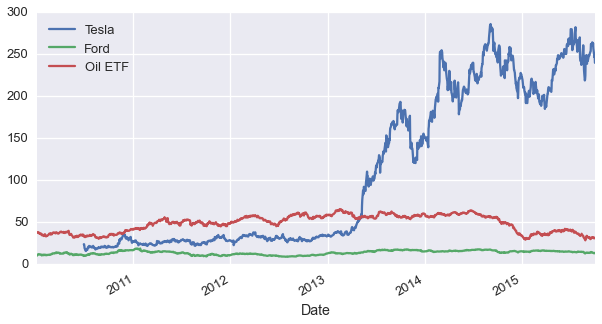

In [10]:
prices.plot(figsize=(10, 5))
plt.show()

Compute Exponentially Weighted Moving Average.

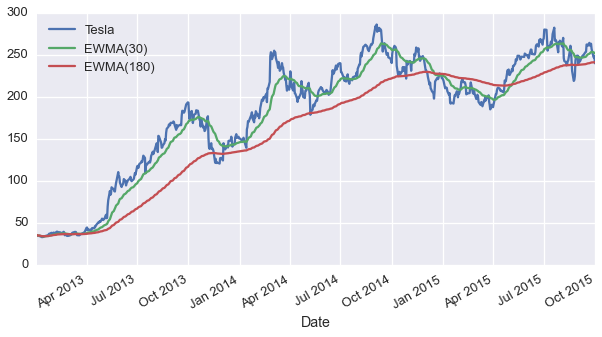

In [11]:
company = 'Tesla'
ewma = prices.ix['2013':, [company]]
for span in [30, 180]:
    ewma['EWMA(' + str(span) + ')'] = pd.ewma(ewma[company], span=span)
ewma.plot(figsize=(10, 5))
plt.show()

Draw them on subplots.

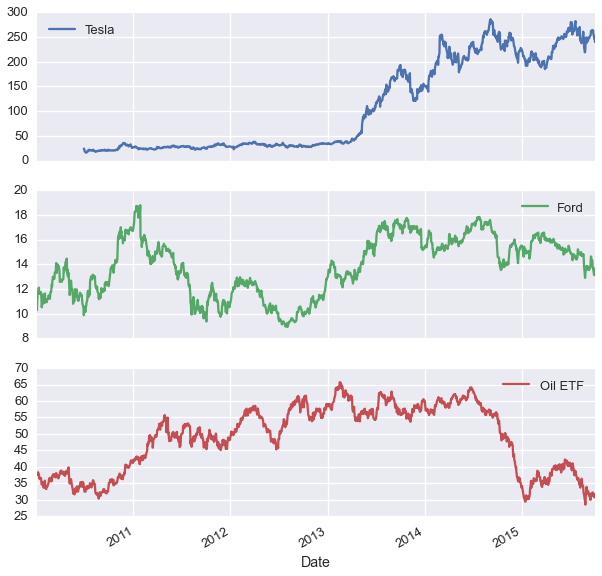

In [12]:
prices.plot(figsize=(10, 10), subplots=True)
plt.show()

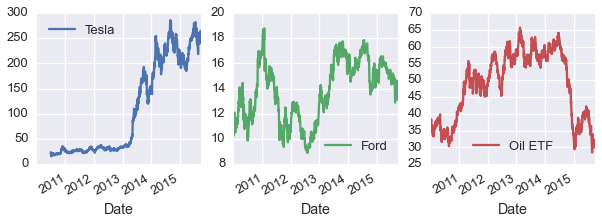

In [13]:
prices.plot(figsize=(10, 3), layout=(1, 3), subplots=True)
plt.show()

Change styling temporarily and add the second Y-axis to the plot.

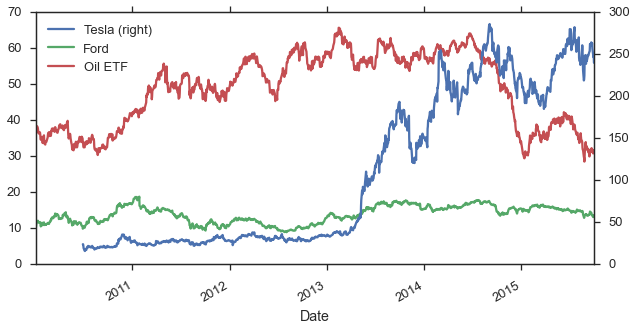

In [14]:
with sns.axes_style('white'):
    sns.set_style('ticks')
    prices.plot(figsize=(10, 5), secondary_y=['Tesla'])
    plt.show()

Compute daily percentage log-returns.

In [15]:
returns = prices.apply(lambda x: 100 * np.log(x / x.shift())).dropna()
print(returns.describe())

        Tesla    Ford  Oil ETF
count 1324.00 1324.00  1324.00
mean     0.17    0.02    -0.00
std      3.47    1.77     1.70
min    -21.48  -14.40    -7.56
25%     -1.54   -0.91    -0.97
50%      0.10    0.00     0.00
75%      1.91    0.99     1.01
max     21.83    9.41     6.39


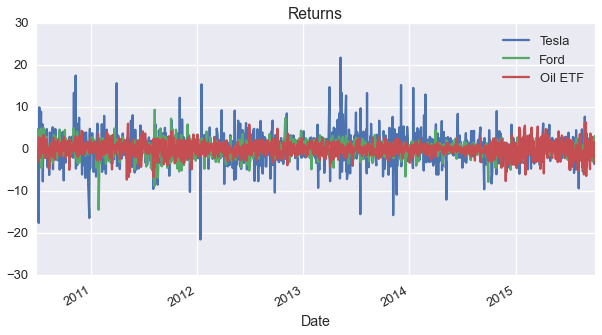

In [16]:
returns.plot(figsize=(10, 5), title='Returns')
plt.show()

Plot distribution of daily returns.

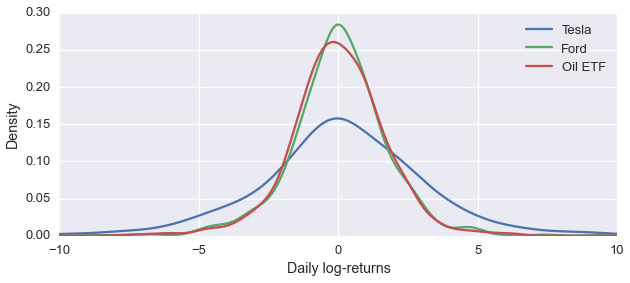

In [17]:
returns.plot(kind='kde', figsize=(10, 4))
plt.xlim([-10, 10])
plt.xlabel('Daily log-returns')
plt.show()

Merge returns and prices.

In [18]:
data = pd.merge(prices, returns, how='outer',
                left_index=True, right_index=True,
                suffixes=[' (price)', ' (return)'])
print(data.shape)
print(data.head())

(1447, 6)
            Tesla (price)  Ford (price)  Oil ETF (price)  Tesla (return)  \
Date                                                                       
2010-01-04            nan         10.28            37.47             nan   
2010-01-05            nan         10.96            37.81             nan   
2010-01-06            nan         11.37            37.90             nan   
2010-01-07            nan         11.66            37.89             nan   
2010-01-08            nan         11.69            38.38             nan   

            Ford (return)  Oil ETF (return)  
Date                                         
2010-01-04            nan               nan  
2010-01-05            nan               nan  
2010-01-06            nan               nan  
2010-01-07            nan               nan  
2010-01-08            nan               nan  


Compute cumulative return for each stock.

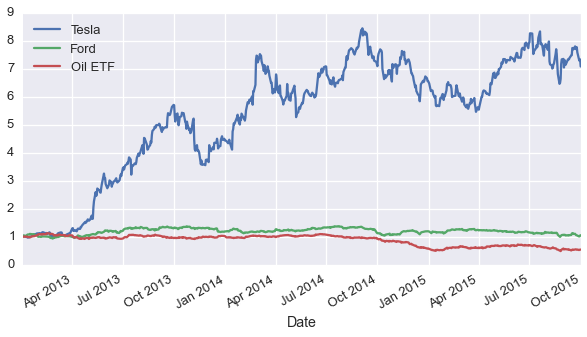

In [19]:
cumret = returns.ix['2013':].cumsum().apply(lambda x: np.exp(x / 100))
cumret.plot(figsize=(10, 5))
plt.show()

Compute risk-adjusted cumulative return for each company.

        Tesla    Ford  Oil ETF
count 1324.00 1324.00  1324.00
mean     0.05    0.01    -0.00
std      1.00    1.00     1.00
min     -6.20   -8.14    -4.46
25%     -0.44   -0.52    -0.57
50%      0.03    0.00     0.00
75%      0.55    0.56     0.59
max      6.30    5.32     3.77


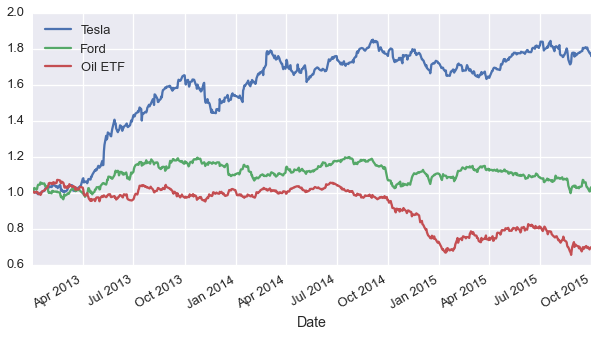

In [20]:
risk_adj = returns.apply(lambda x: x / x.std())
print(risk_adj.describe())

cumret = risk_adj.ix['2013':].cumsum().apply(lambda x: np.exp(x / 100))
cumret.plot(figsize=(10, 5))
plt.show()

Compute average returns by month for each company.

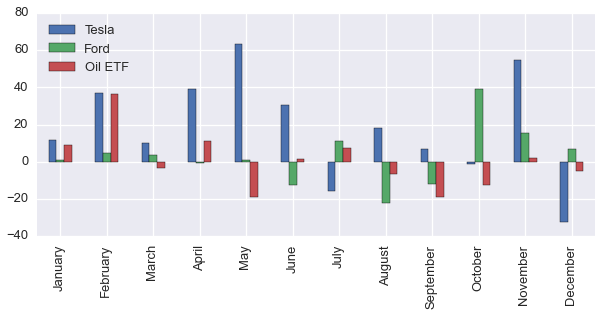

In [21]:
import calendar

ret_month = returns.copy()
ret_month = ret_month.groupby(lambda x: x.month).mean() * 100

plot = ret_month.plot(kind='bar', figsize=(10, 4))
ticks = [calendar.month_name[int(item.get_text())] for item in plot.get_xticklabels()]
plt.gca().set_xticklabels(ticks)
plt.show()

Compute annual returns for each company.

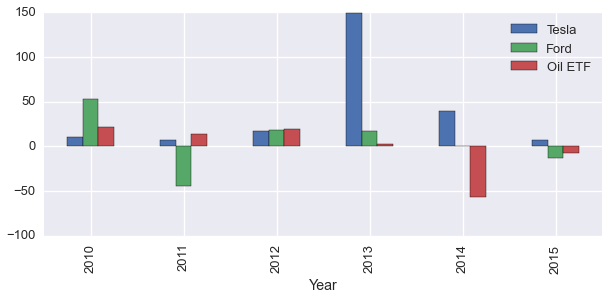

In [22]:
monthly = returns.resample('a', how='sum')
monthly['Year'] = monthly.index.year
monthly.reset_index(inplace=True, drop=True)
monthly.set_index('Year', inplace=True)

monthly.plot(kind='bar', figsize=(10, 4))
plt.show()

Plot univariate densities, bivariate densities, scatters, and regression lines for all daily stock returns.

/home/khrapov/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/khrapov/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


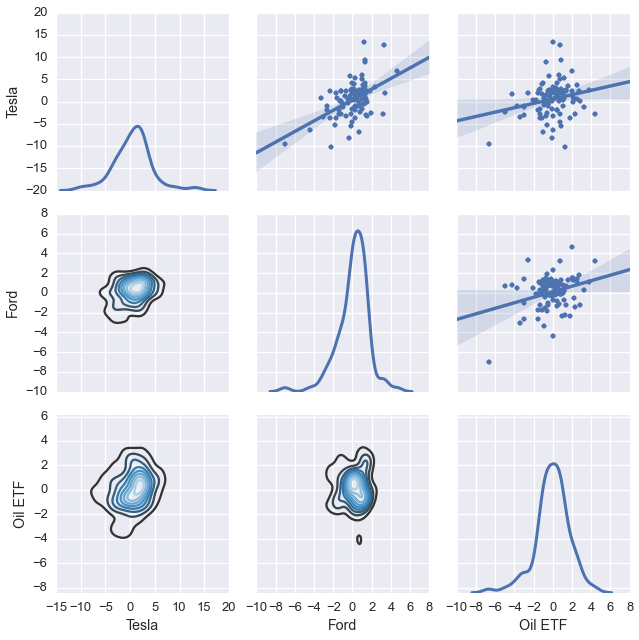

In [23]:
g = sns.PairGrid(returns.sample(100), size=3)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_diag(sns.kdeplot, lw=3, legend=False)
g.map_upper(sns.regplot)
plt.show()

Plot prices, returns, and cumulative returns on the same plot. Save the figure.

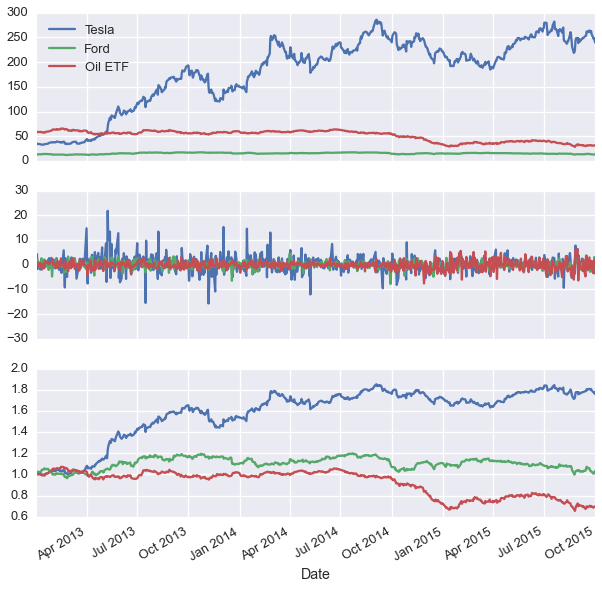

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), sharex=True)
prices.plot(ax=axes[0])
returns.plot(ax=axes[1])
cumret.plot(ax=axes[2])
axes[1].legend().set_visible(False)
axes[2].legend().set_visible(False)
plt.savefig('../plots/stocks.pdf')
plt.savefig('../plots/stocks.eps')
plt.show()

Save plot iteratively for each modification. This will produce a pseudo-animation in LaTeX presentation.

In [25]:
company = 'Tesla'
ewma = prices.ix['2013':, [company]]

lines = []
for count, span in enumerate([30, 180]):
    name = 'EWMA(' + str(span) + ')'
    ewma[name] = pd.ewma(ewma[company], span=span)

ax = ewma.plot(figsize=(4, 3))
plt.legend(loc='lower right')
plt.tight_layout()
nlines = len(ax.lines)
for count, line in enumerate(ax.lines[::-1]):
    plt.savefig('../plots/tesla_' + str(nlines - 1 - count) + '.pdf')
    line.remove()
plt.close()